In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict



root_metric_path ="/home/yannh/Documents/uni/phd/rivers_deep/metrics/"

models = [
    "tiramisu_htira-bclf",
    "unet-fcc", 
    "r2unet-fcc", 
    "attunet-fcc", 
    "r2attunet-fcc",
    ]

weight_modes = [
    #"swl",
    "regular",
]

trainingset = "Keplerv18"



CONF_MATRIX_NAMES = [
    "train_img", 
    "train_pixel",
    "val_img",
    "val_pixel"
    ]

METRIC_NAMES = [
    "accuracy", # correct predictive value, (TP + TN) / N
    "recall", # True positive rate, TP / (TP + FN)
    "precision" # Positive predictive value of specific class, (TP) / (TP + FP) = TP / P
]

CLASS_IDS = {
    "noise": 0,
    "resonance": 1,
    "trojan": 2
}

CLASS_IDS_2D = {
    "noise": 0,
    "all": 1
}


def reduce_to_2classes(cm):
    new_cm = np.empty((2,2), dtype=int)
    new_cm[0,0] = cm[0,0]
    new_cm[1,1] = cm[1:,1:].sum()
    new_cm[0,1] = cm[0,1:].sum()
    new_cm[1,0] = cm[1:,0].sum()
    return new_cm


def get_accuracy(cm):
    return np.diag(cm).sum()/cm.sum()
    
    
def get_recall(cm, class_id):
    return cm[class_id,class_id]/cm[class_id,:].sum()


def get_precision(cm, class_id):
    return cm[class_id,class_id]/cm[:,class_id].sum()


def sliding_mean(data, window_size=10):
    result = np.empty(data.size - window_size)
    for i in range(window_size, data.size-window_size):
        result[i] = np.mean(data[i-window_size:i])
    return result


def slope(data):
    return (np.roll(data,1,0) - data)[1:]



def fill_data(metrics):
    
    n_metric = len(metrics)
    
    data = defaultdict(dict)

    data["epoch"] = np.empty(n_metric)
    data["epoch_completion_ratio"] = np.empty(n_metric)
    data["n_batch_eval"] = np.empty(n_metric)
    data["train_loss"] = np.empty(n_metric)
    data["val_loss"] = np.empty(n_metric)
    data["train_img_cm"] = np.empty((n_metric, 3,3))
    data["train_pixel_cm"] = np.empty((n_metric, 3,3))
    data["val_img_cm"] = np.empty((n_metric, 3,3))
    data["val_pixel_cm"] = np.empty((n_metric, 3,3))
    data["train_img_cm2d"] = np.empty((n_metric, 2,2))
    data["train_pixel_cm2d"] = np.empty((n_metric, 2,2))
    data["val_img_cm2d"] = np.empty((n_metric, 2,2))
    data["val_pixel_cm2d"] = np.empty((n_metric, 2,2))

    for i_m, m in enumerate(metrics):
        for k, v in m.items():
        
            data[k][i_m] = v   
            
        for name in CONF_MATRIX_NAMES:
            cm = m[f"{name}_cm"]
            cm2d = reduce_to_2classes(cm)
            data[f"{name}_cm2d"][i_m] = cm2d
            data[f"{name}_accuracy"][i_m] = get_accuracy(cm)
            data[f"{name}2d_accuracy"][i_m] = get_accuracy(cm2d)
            for k,v in CLASS_IDS.items():
                data[f"{name}_{k}_recall"][i_m] = get_recall(cm, v)
                data[f"{name}_{k}_precision"][i_m] = get_precision(cm, v)
            for k, v in CLASS_IDS_2D.items():
                data[f"{name}2d_{k}_recall"][i_m] = get_recall(cm2d, v)
                data[f"{name}2d_{k}_precision"][i_m] = get_precision(cm2d, v)


    epoch = data["epoch"] + data["epoch_completion_ratio"]
    return data, epoch

In [2]:
result = defaultdict(dict)
for m in models:
    for w in weight_modes:
        metric_path = f"{root_metric_path}{m}_{w}_trainingset_{trainingset}/{m}_{w}.pkl"
        
        try:
            with open(metric_path, "rb") as f:
                metrics = pd.read_pickle(f)
        except FileNotFoundError:
            print(f"model {m} weight mode {w} with trainingset {trainingset} not found. Skipping...")
            continue
        
        data, epoch = fill_data(metrics)
        
        # fromiter converts dict_keys to np.array
        best_loss_epoch_arg = data[f"val_loss"].argmin()
        recall_all_img = np.fromiter(data[f"val_img2d_all_recall"].values(), dtype=float)
        precision_all_img = np.fromiter(data[f"val_img2d_all_precision"].values(), dtype=float)
        accuracy_img = np.fromiter(data[f"val_img2d_accuracy"].values(), dtype=float)
        recall_all_px = np.fromiter(data[f"val_pixel2d_all_recall"].values(), dtype=float)
        precision_all_px = np.fromiter(data[f"val_pixel2d_all_precision"].values(), dtype=float)
        accuracy_px = np.fromiter(data[f"val_pixel2d_accuracy"].values(), dtype=float)
        
        recall_noise_px = np.fromiter(data[f"val_pixel_noise_recall"].values(), dtype=float)
        precision_noise_px = np.fromiter(data[f"val_pixel_noise_precision"].values(), dtype=float)
        
       
        
        result[f"{m}_{w}"] = [accuracy_img[best_loss_epoch_arg], recall_all_img[best_loss_epoch_arg], precision_all_img[best_loss_epoch_arg], accuracy_px[best_loss_epoch_arg], recall_all_px[best_loss_epoch_arg], precision_all_px[best_loss_epoch_arg], recall_noise_px[best_loss_epoch_arg], precision_noise_px[best_loss_epoch_arg]]
        
        
    
            


/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


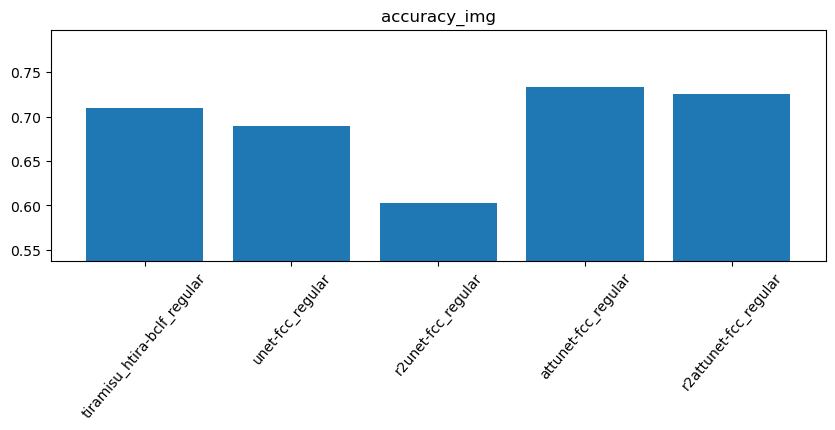

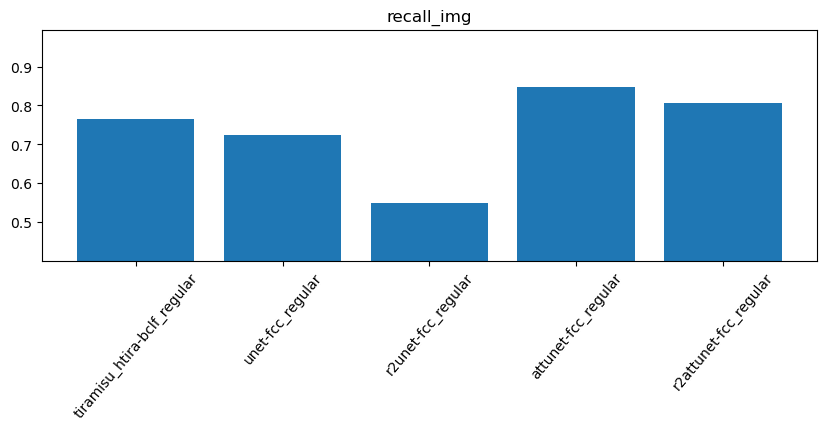

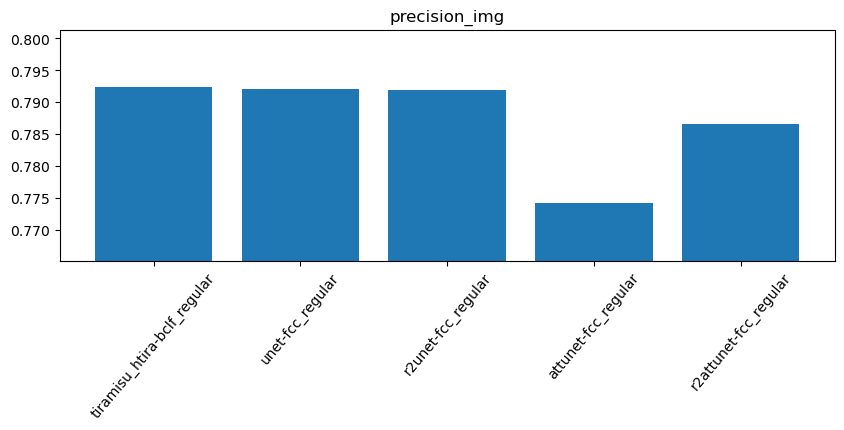

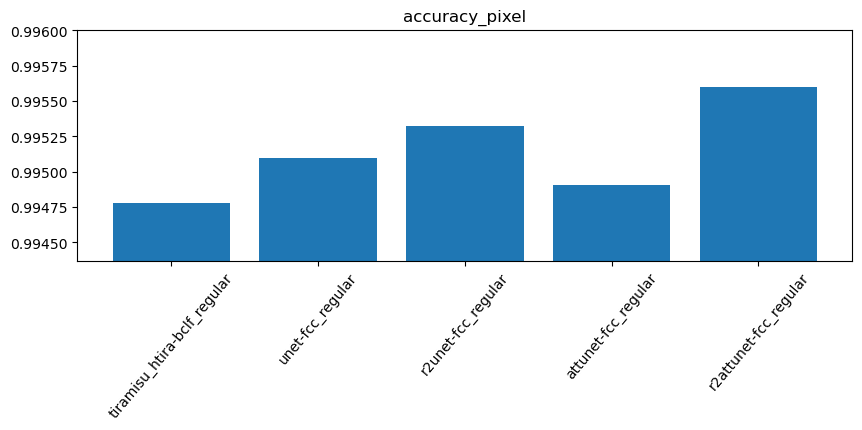

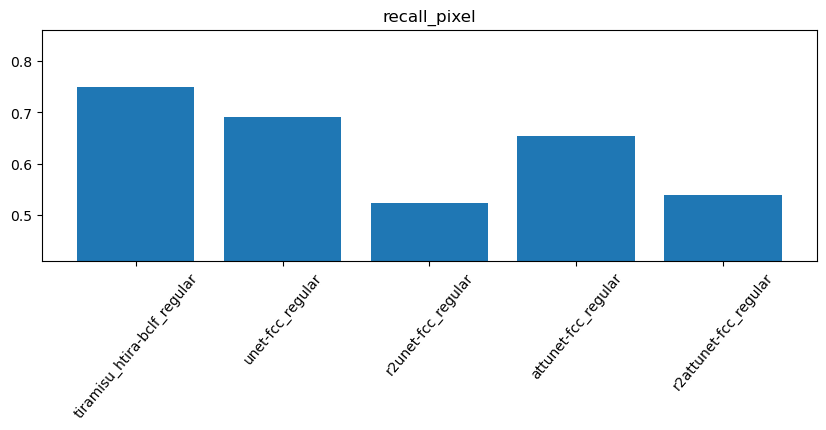

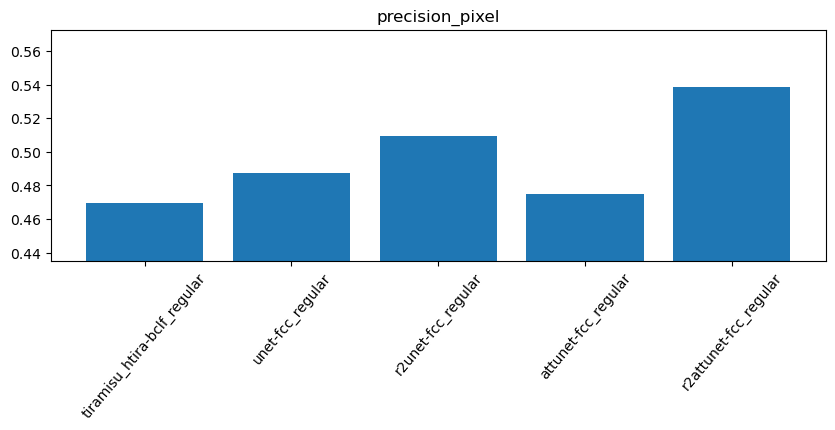

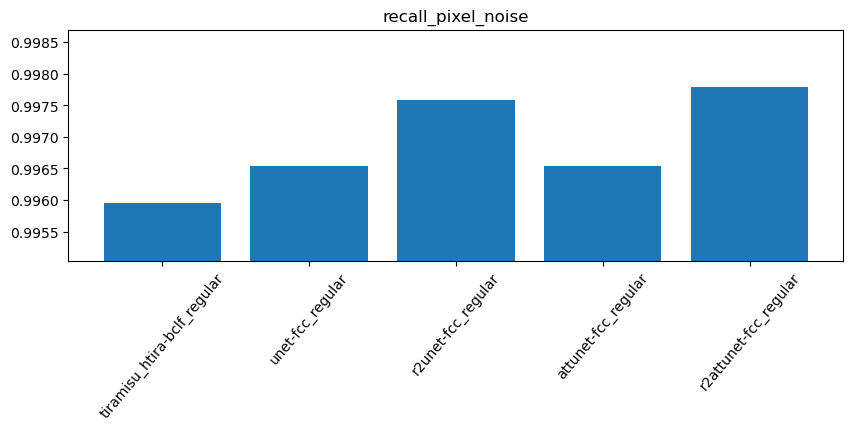

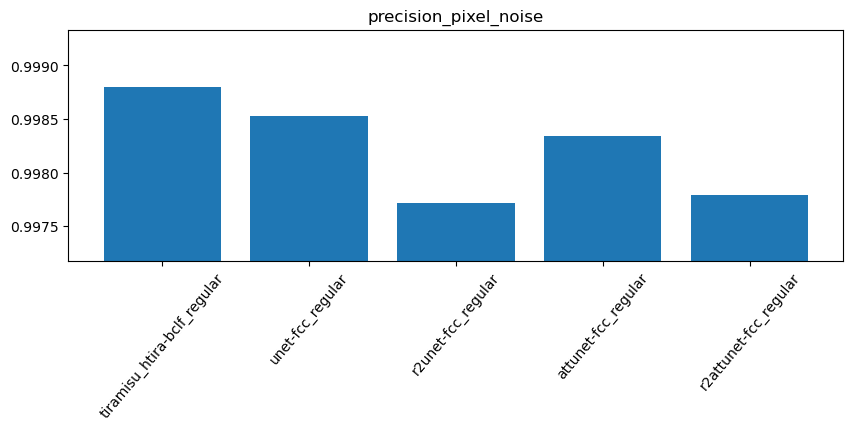

In [3]:
metric_name_plot = [
    "accuracy_img", # correct predictive value, (TP + TN) / N
    "recall_img", # True positive rate, TP / (TP + FN)
    "precision_img", # Positive predictive value of specific class, (TP) / (TP + FP) = TP / P
    "accuracy_pixel", 
    "recall_pixel",
    "precision_pixel",
    "recall_pixel_noise",
    "precision_pixel_noise",
]

for i, m in enumerate(metric_name_plot):
    fig, ax = plt.subplots(1,1, figsize=(10,3))
    ax.set_title(m)
    res = np.array([v[i] for v in result.values()])
    ax.bar(np.arange(len(result)), res, tick_label=result.keys())
    ax.set_xticklabels(result.keys(), rotation = 50) 
    dres = res.max() - res.min()
    ylim_min =  max(0, res.min()-0.5*dres)
    ylim_max = min(1, res.max()+0.5*dres)
    ax.set(ylim=(ylim_min, ylim_max))  
    plt.show()

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


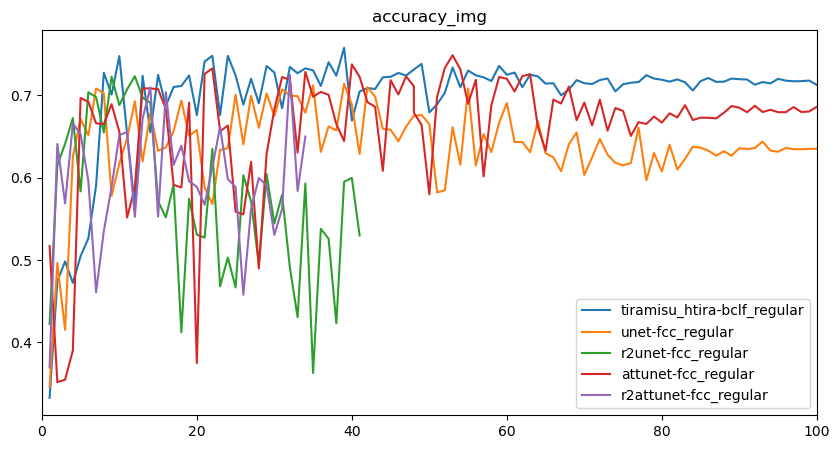

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


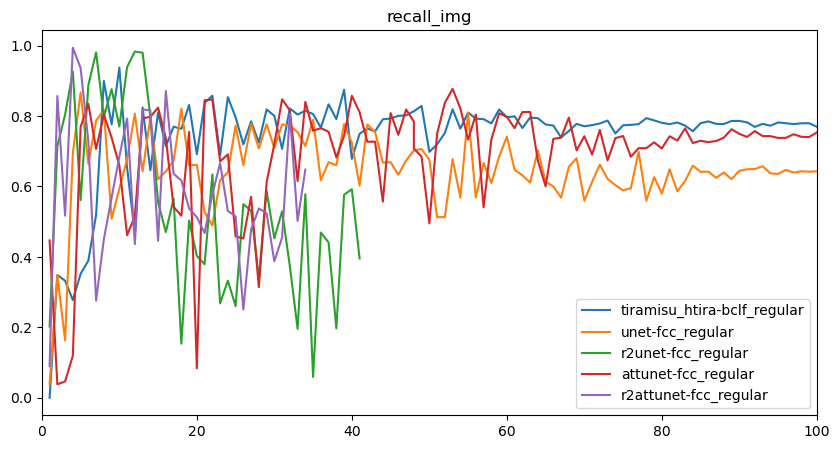

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


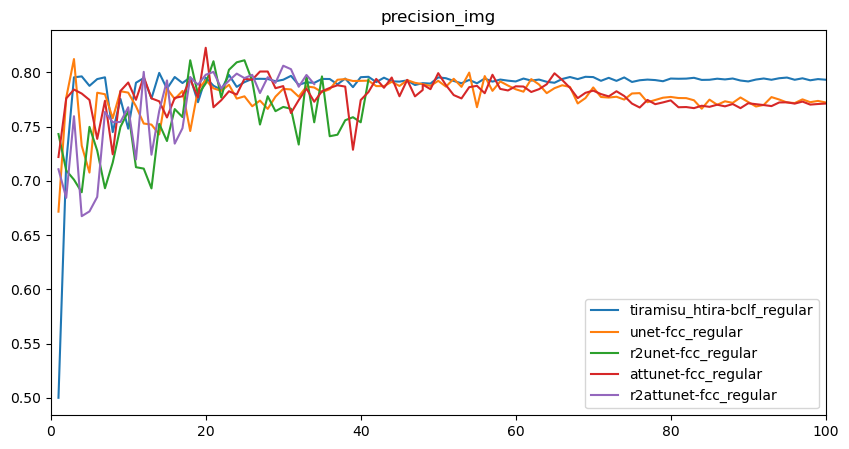

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


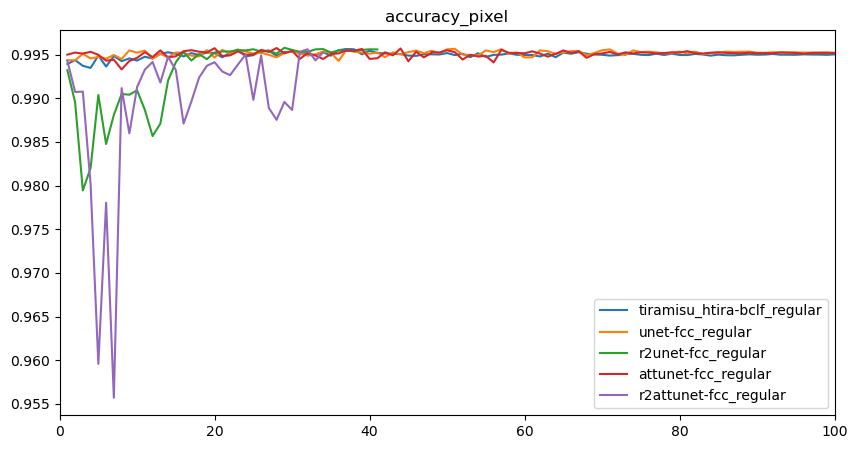

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


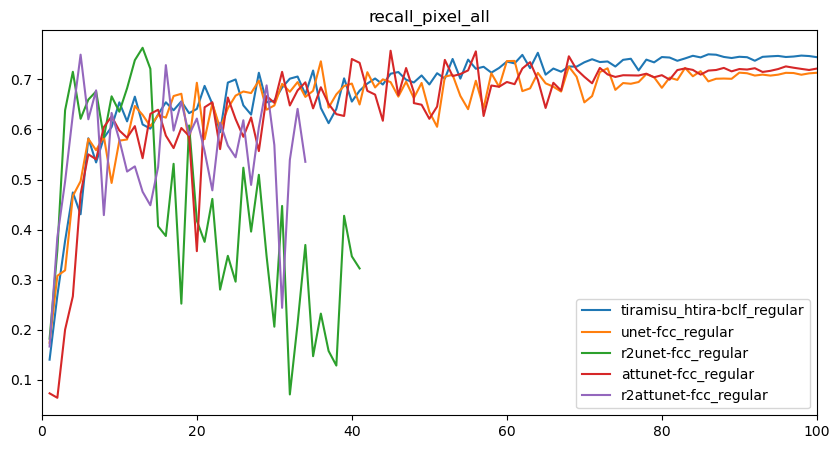

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


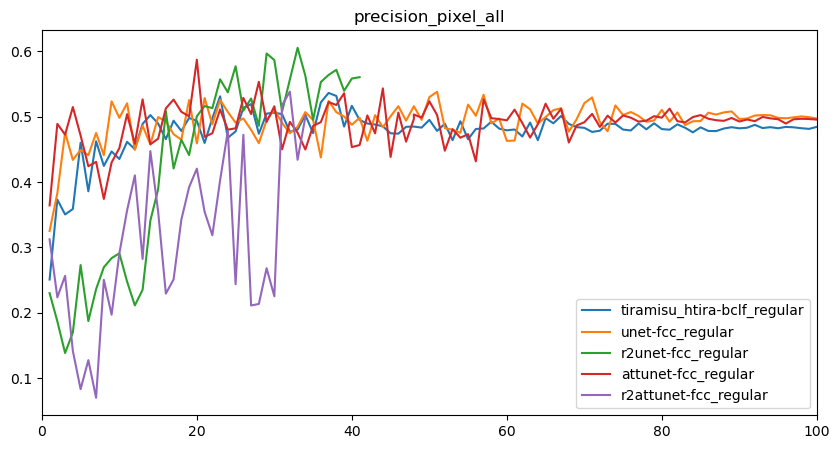

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


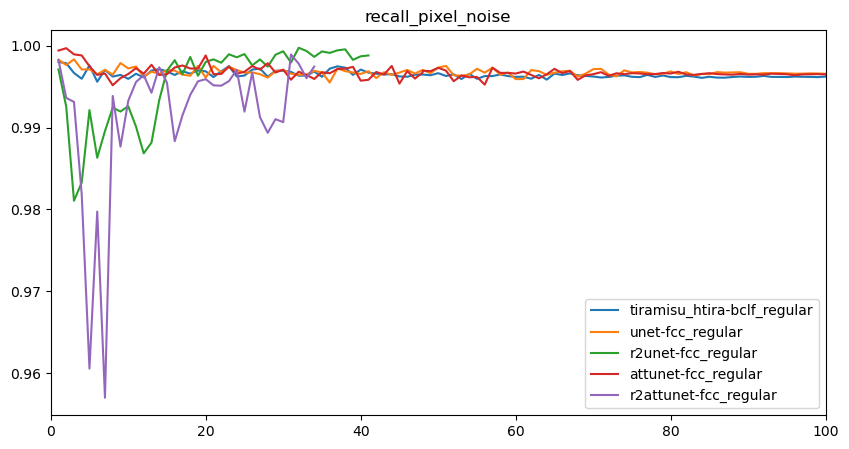

/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()
/tmp/ipykernel_297589/1171384875.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return cm[class_id,class_id]/cm[:,class_id].sum()


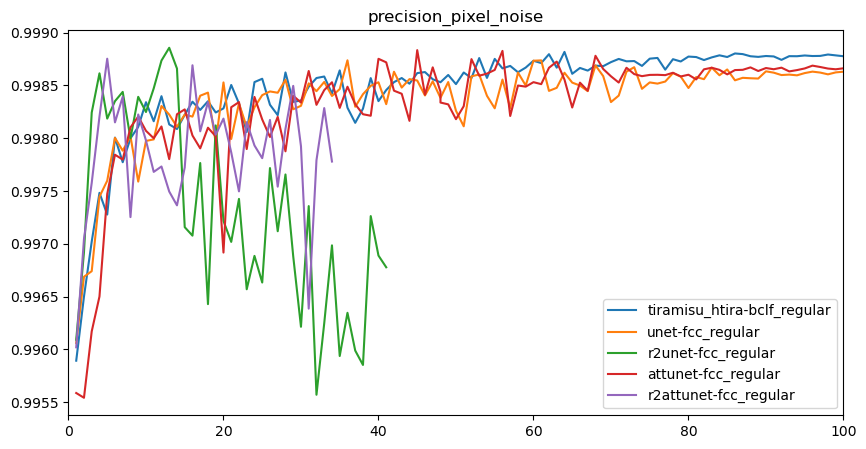

In [4]:
result = defaultdict(dict)

for i in range(8):
    
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    for m in models:
        for w in weight_modes:
            metric_path = f"{root_metric_path}{m}_{w}_trainingset_{trainingset}/{m}_{w}.pkl"
            
            try:
                with open(metric_path, "rb") as f:
                    metrics = pd.read_pickle(f)
            except FileNotFoundError:
                print(f"model {m} weight mode {w} with trainingset {trainingset} not found. Skipping...")
                continue
            
            data, epoch = fill_data(metrics)
            
            # fromiter converts dict_keys to np.array
            best_loss_epoch_arg = data[f"val_loss"].argmin()
            recall_all_img = np.fromiter(data[f"val_img2d_all_recall"].values(), dtype=float)
            precision_all_img = np.fromiter(data[f"val_img2d_all_precision"].values(), dtype=float)
            accuracy_img = np.fromiter(data[f"val_img2d_accuracy"].values(), dtype=float)
            recall_all_px = np.fromiter(data[f"val_pixel2d_all_recall"].values(), dtype=float)
            precision_all_px = np.fromiter(data[f"val_pixel2d_all_precision"].values(), dtype=float)
            recall_noise_px = np.fromiter(data[f"val_pixel2d_noise_recall"].values(), dtype=float)
            precision_noise_px = np.fromiter(data[f"val_pixel2d_noise_precision"].values(), dtype=float)

            

            accuracy_px = np.fromiter(data[f"val_pixel2d_accuracy"].values(), dtype=float)
            
            chosen_metric = [accuracy_img, recall_all_img, precision_all_img, accuracy_px, recall_all_px, precision_all_px, recall_noise_px, precision_noise_px][i]
            
            chosen_label = ["accuracy_img", "recall_img", "precision_img", "accuracy_pixel", "recall_pixel_all", "precision_pixel_all", "recall_pixel_noise", "precision_pixel_noise"][i]    
            
            box_shape = 0
        
            if chosen_metric.size < box_shape:
                box_shape = 0
            
            if box_shape:
                smooth_metric = np.convolve(chosen_metric, np.ones(box_shape)/box_shape, mode="valid")
            else:
                smooth_metric = chosen_metric
                
        
            if box_shape:
                ax.plot(epoch[:-box_shape+1], smooth_metric, label=f"{m}_{w}")
            else:
                ax.plot(epoch, smooth_metric, label=f"{m}_{w}")
            
            ax.legend()
            ax.set_title(chosen_label)
            ax.set(xlim=(0,100))
    plt.show()
        